In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ag-news-dataset/ANLP-2/train.csv
/kaggle/input/ag-news-dataset/ANLP-2/test.csv
/kaggle/input/hindivocab/hi.vocabfreq.tsv


In [ ]:
!wget https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/data/monolingual/indicnlp_v1/sentence/hi.txt.gz

--2024-04-09 05:21:24--  https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/data/monolingual/indicnlp_v1/sentence/hi.txt.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3501961592 (3.3G) [text/plain]
Saving to: 'hi.txt.gz'

hi.txt.gz           100%[===================>]   3.26G  30.5MB/s    in 1m 51s  

2024-04-09 05:23:16 (30.0 MB/s) - 'hi.txt.gz' saved [3501961592/3501961592]



In [ ]:
!wget https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/data/monolingual/indicnlp_v1/corpus_stats/hi.vocabfreq.tsv.gz

--2024-04-09 05:23:17--  https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/data/monolingual/indicnlp_v1/corpus_stats/hi.vocabfreq.tsv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40556425 (39M) [text/tab-separated-values]
Saving to: 'hi.vocabfreq.tsv.gz'

hi.vocabfreq.tsv.gz 100%[===================>]  38.68M  18.9MB/s    in 2.0s    

2024-04-09 05:23:20 (18.9 MB/s) - 'hi.vocabfreq.tsv.gz' saved [40556425/40556425]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv

In [ ]:
!pip install indic-nlp-library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 18.0 MB/s eta 0:00:00


In [ ]:
corpus_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/hi.txt.gz'
vocabulary_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/hi.vocabfreq.tsv.gz'
folder_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/'


Need not run next 2 cells

In [ ]:
import gzip
import shutil
with gzip.open(corpus_path, 'rb') as f_in:
    with open(folder_path +'hi.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [ ]:
with gzip.open(vocabulary_path, 'rb') as f_in:
    with open(folder_path + 'hi.vocabfreq.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
file=open(folder_path + 'hi.txt','r')
hindisent=[]
i=0
for line in file:
    if i<100000:
        hindisent.append(line)
        i=i+1
    else:
        break

In [ ]:
hindisent[2]

'पी - एक्स - एक्स - एल कैप्सूल एक 100 % हर्बल जड़ी बूटी युक्त एक कैप्सूल के रूप में दवाई है जोकि सेक्स करते समय व्यक्ति के शरीर में होने वाली कमजोरी , लिंग में तनाव की कमी , शरीर में दर्द , आदि शिकायतों से राहत प्रदान करने में मदद करता है\n'

In [ ]:
from indicnlp.tokenize import indic_tokenize
tokenized_hindi=[]
tokenized_hindi_reverse = []
for i in hindisent:
    tokenized_hindi.append(indic_tokenize.trivial_tokenize(i,'hi'))
    tokenized_hindi_reverse.append(indic_tokenize.trivial_tokenize(i,'hi')[::-1])

In [ ]:
data={'tokenized texts':tokenized_hindi}
data_reverse={'tokenized texts':tokenized_hindi_reverse}

In [ ]:
df=pd.DataFrame(data)
df_reverse=pd.DataFrame(data_reverse)

In [ ]:
len(df.iloc[0][0])

21

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
train_dataset=df
train_dataset_reverse=df_reverse

In [ ]:
train_dataset.columns

Index(['tokenized texts'], dtype='object')

In [ ]:
mxlen=[]
for column in train_dataset[train_dataset.columns[0]]:
    mxlen.append(len(column))

Do not execute next cell

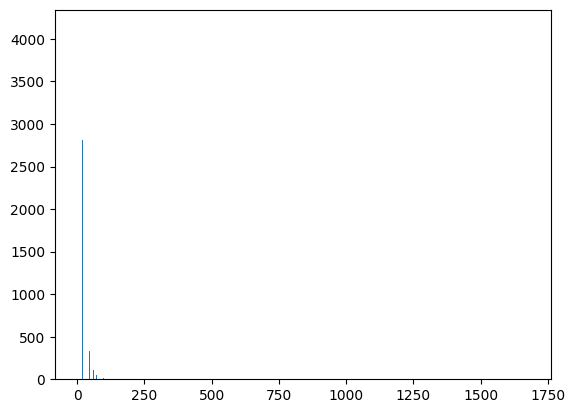

In [ ]:
import matplotlib.pyplot as plt
z=plt.hist(mxlen,bins=10000)

Since Most of the prob. lies in the first 3 Bins that are of length until 35 so we take the mxlen of 55

In [ ]:
vocab=pd.read_csv(folder_path +'hi.vocabfreq.tsv',sep='\t',quoting=csv.QUOTE_NONE,encoding='utf-8')

Initial Vocab from file


In [ ]:
word_to_ix={}
ix_to_word={}

In [ ]:
word_to_ix['<UNK>']=1
word_to_ix['<PAD>']=0
ix_to_word[1]='<UNK>'
ix_to_word[0]='<PAD>'

In [ ]:
for idx,word in  enumerate(vocab[vocab.columns[0]]):
    word_to_ix[word]=idx+2
    ix_to_word[idx+2]=word

Modified Vocab indexing since original Vocab is 5.5 M tokens long


In [ ]:
dummy_vocab=[]
for i in tokenized_hindi:
    dummy_vocab.extend(i)
dummy_vocab=set(dummy_vocab)
len(dummy_vocab)
modified_vocab=[]
for i in dummy_vocab:
    if i in word_to_ix.keys():
        modified_vocab.append(i)
len(modified_vocab)

96234

In [ ]:
word_to_ix={}
ix_to_word={}
word_to_ix['<UNK>']=1
word_to_ix['<PAD>']=0
ix_to_word[1]='<UNK>'
ix_to_word[0]='<PAD>'

In [ ]:
for idx,word in  enumerate(modified_vocab):
    word_to_ix[word]=idx+2
    ix_to_word[idx+2]=word

In [ ]:
class Datafetch(Dataset):
    def __init__(self,split):
        data=[]
        labels=[]
        for x in tqdm(split[split.columns[0]],desc='Generate next word prediction data'):
            if len(x)<1 or x[0]=='=':continue
            indices=[word_to_ix.get(word,1) for word in x]
            if len(indices)<55:
                indices=indices+(55-len(indices))*[0]
            elif len(indices)>55:
                indices=indices[:55]
            lb_indices=[word_to_ix.get(word,1) for word in x[1:]]
            if len(lb_indices)<55:
                lb_indices=lb_indices+(55-len(lb_indices))*[0]
            elif len(lb_indices)>55:
                lb_indices=lb_indices[:55]
            data.append(indices)
            labels.append(lb_indices)
        self.data=tensor(data)
        self.labels=tensor(labels)
    def __len__(self)->int:
        return len(self.data)
    def __getitem__(self,index:int):
        return self.data[index],self.labels[index]

In [ ]:
train_dataset_for_lstm_prediction=train_dataset

In [ ]:
train_dataset_with_dataloader_type=Datafetch(train_dataset_for_lstm_prediction)

Generate next word prediction data: 100%|██████████| 100000/100000 [00:01<00:00, 75460.87it/s]


In [ ]:
train_dataloader=DataLoader(train_dataset_with_dataloader_type,batch_size=32,shuffle=True,pin_memory=True)

In [ ]:
data,labels=next(iter(train_dataloader))

In [ ]:
data.shape

torch.Size([32, 55])

In [ ]:
labels.shape

torch.Size([32, 55])

In [ ]:
print(data[3],labels[3])

tensor([95954, 69633, 46680, 70617,  2365, 93043, 54091, 10105, 93701, 85266,
        38607, 71051, 77126, 34952, 90292, 71681, 22692, 71565, 63051,  7190,
            1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]) tensor([69633, 46680, 70617,  2365, 93043, 54091, 10105, 93701, 85266, 38607,
        71051, 77126, 34952, 90292, 71681, 22692, 71565, 63051,  7190,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])


In [ ]:
!wget https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/embedding/indicnlp.v1.hi.vec.gz

In [ ]:
!rm /kaggle/working/hi.txt.gz

rm: cannot remove '/kaggle/working/hi.txt.gz': No such file or directory


Need not run next cell

In [ ]:
with gzip.open(folder_path + 'indicnlp.v1.hi.vec.gz', 'rb') as f_in:
    with open(folder_path +'indicnlp.v1.hi.vec', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
word_vectors={}
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format(folder_path+'indicnlp.v1.hi.vec.gz', binary=False,)
# vocab_size = len(word_to_index)
# embedding_dim = 300
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in word_to_index.items():
#     try:
#         w2v_vector = w2v_model.get_vector(word)
#         embedding_matrix[i] = w2v_vector
#     except:
#         embedding_matrix[i] = np.zeros((1,300))
# embedding_matrix = torch.tensor(embedding_matrix,dtype = torch.float)



In [ ]:
import pickle

# File path to save the pickle file
pickle_file_path = folder_path +'w2v_model.pkl'

# Open file in binary write mode
with open(pickle_file_path, 'wb') as file:
    # Dump the data into the file
    pickle.dump(w2v_model, file)


In [ ]:
import pickle

# File path from where to load the pickle file
pickle_file_path = folder_path + 'w2v_model.pkl'

# Open file in binary read mode
with open(pickle_file_path, 'rb') as file:
    # Load the data from the file
    w2v_model = pickle.load(file)

# Print the loaded data
# print(w2v_model)


In [ ]:
# with open(folder_path +'indicnlp.v1.hi.vec','r') as f:
#     next(f)

#     for line in f:
#         word,*vector_components=line.strip().split()
#         vector=[float(component) for component in vector_components]
#         word_vectors[word]=vector

In [ ]:
len(list(word_to_ix.keys()))

96236

In [ ]:

wt_mat=torch.zeros(size=(len(list(word_to_ix.keys())),300))
words_found=0
for word,i in zip(word_to_ix.keys(),range(len(list(word_to_ix.keys())))):
  try:
    wt_mat[i]=torch.tensor(w2v_model[word],dtype=torch.float)
    words_found+=1
  except KeyError:
    wt_mat[i]=torch.rand(size=(1,300))

In [ ]:
words_found

85816

In [ ]:
wt_mat.to(device)

tensor([[ 0.9225,  0.4197,  0.9965,  ...,  0.9767,  0.8039,  0.8736],
        [ 0.2208,  0.4336,  0.5459,  ...,  0.6972,  0.4620,  0.3142],
        [-0.4710,  0.1055, -0.4710,  ..., -0.4624, -0.4414, -0.2999],
        ...,
        [ 0.7397, -0.1825, -0.0165,  ...,  0.1592, -0.0420, -0.1098],
        [-0.2191, -0.3703, -0.5594,  ...,  0.1314,  0.2545, -0.4683],
        [-0.0120, -0.2261, -0.2116,  ..., -0.2619,  0.0485,  0.1566]],
       device='cuda:0')

In [ ]:
embeddings=torch.tensor(wt_mat,dtype=torch.float)
embedding=nn.Embedding.from_pretrained(embeddings,freeze=True,padding_idx=0)
print(embedding.weight.shape)

torch.Size([96236, 300])


<ipython-input-37-fcb71a72dd58>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(wt_mat,dtype=torch.float)


In [ ]:
device

'cuda'

In [ ]:
embedding.to(device)

Embedding(96236, 300, padding_idx=0)

In [ ]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        #self.embeddings=nn.Embedding(vocab_size,embedding_dim)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        # self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        # self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)

        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self,embeddingdata):
        emb=torch.tensor(self.embedding(embeddingdata.to(device)))

        emb_f=emb
        # emb_b=emb.flip(1)

        o1f1,h1f1=self.lstmf1(emb_f)
        o2f2,h2f2=self.lstmf2(o1f1)
        # o2f2=o2f2+o1f1
        # h2f2=h2f2+h1f1
        # o1b1,h1b1=self.lstmb1(emb_b)
        # o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        # o2b2=o2b2+o1b1
        # h2b2=h2b2+h1b1

        # weighted_vector_emb=torch.cat([emb_f,emb_b],dim=2)
        # weighted_vector_h1=torch.cat([o1f1,o1f1],dim=2)
        # weighted_vector_h2=torch.cat([o1f1,o2f2],dim=2)
        output =self.linear(o2f2)
        return (output,o1f1,o2f2)

In [ ]:
elmo=ElmoProcessor(len(word_to_ix),300,300,embedding)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(elmo.parameters(),1e-3)

In [ ]:
elmo.to(device)

ElmoProcessor(
  (lstmf1): LSTM(300, 300, batch_first=True)
  (lstmf2): LSTM(300, 300, batch_first=True)
  (embedding): Embedding(96236, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=96236, bias=True)
)

In [ ]:
for epoch in range(5):
    train_loss=0
    elmo.train()
    for batch in tqdm(train_dataloader,desc="Training Forward LM"):
        x_train,y_train=batch
        optimizer.zero_grad()

        output,_,_=elmo(x_train.to(device))
        loss=loss_fn(output.view(-1,output.size(2)),y_train.view(-1).to(device))
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training Forward LM:   0%|          | 0/3125 [00:00<?, ?it/s]<ipython-input-40-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training Forward LM: 100%|██████████| 3125/3125 [08:13<00:00,  6.33it/s]


6608.957137227058


Training Forward LM: 100%|██████████| 3125/3125 [08:13<00:00,  6.33it/s]


5610.295282959938


Training Forward LM: 100%|██████████| 3125/3125 [08:14<00:00,  6.32it/s]


5155.732299745083


Training Forward LM: 100%|██████████| 3125/3125 [08:14<00:00,  6.31it/s]


4779.413933694363


Training Forward LM: 100%|██████████| 3125/3125 [08:14<00:00,  6.31it/s]

4453.279629826546


In [ ]:
torch.save(elmo,folder_path +'pretrained_forward_model')

Bckward LM training

In [ ]:
train_dataset_for_lstm_prediction=train_dataset_reverse

In [ ]:
train_dataset_with_dataloader_type=Datafetch(train_dataset_for_lstm_prediction)

Generate next word prediction data: 100%|██████████| 100000/100000 [00:02<00:00, 37632.57it/s]


In [ ]:
train_dataloader=DataLoader(train_dataset_with_dataloader_type,batch_size=32,shuffle=True,pin_memory=True)

In [ ]:
data,labels=next(iter(train_dataloader))

In [ ]:
data.shape

torch.Size([32, 55])

In [ ]:
labels.shape

torch.Size([32, 55])

In [ ]:
print(data[3],labels[3])

tensor([    1,     1, 49976, 78210, 72319, 55232, 56113, 67945, 71505, 44413,
        86174, 41500, 78210, 22608, 16283, 14173, 94457, 86698, 10061,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]) tensor([    1, 49976, 78210, 72319, 55232, 56113, 67945, 71505, 44413, 86174,
        41500, 78210, 22608, 16283, 14173, 94457, 86698, 10061,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])


In [ ]:
elmo_backward=ElmoProcessor(len(word_to_ix),300,300,embedding)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(elmo_backward.parameters(),1e-3)

In [ ]:
elmo_backward.to(device)

ElmoProcessor(
  (lstmf1): LSTM(300, 300, batch_first=True)
  (lstmf2): LSTM(300, 300, batch_first=True)
  (embedding): Embedding(96236, 300, padding_idx=0)
  (linear): Linear(in_features=300, out_features=96236, bias=True)
)

In [ ]:
for epoch in range(5):
    train_loss=0
    elmo_backward.train()
    for batch in tqdm(train_dataloader,desc="Training Backward LM"):
        x_train,y_train=batch
        optimizer.zero_grad()

        output,_,_=elmo_backward(x_train.to(device))
        loss=loss_fn(output.view(-1,output.size(2)),y_train.view(-1).to(device))
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training Backward LM:   0%|          | 0/3125 [00:00<?, ?it/s]<ipython-input-40-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training Backward LM: 100%|██████████| 3125/3125 [08:11<00:00,  6.36it/s]


7208.391219615936


Training Backward LM: 100%|██████████| 3125/3125 [08:13<00:00,  6.33it/s]


6174.317501664162


Training Backward LM: 100%|██████████| 3125/3125 [08:14<00:00,  6.32it/s]


5729.040210902691


Training Backward LM: 100%|██████████| 3125/3125 [08:15<00:00,  6.30it/s]


5362.13204729557


Training Backward LM: 100%|██████████| 3125/3125 [08:15<00:00,  6.31it/s]

5037.748076677322


In [ ]:
torch.save(elmo_backward,folder_path +'pretrained_backward_model')

In [ ]:

# File path to save the pickle file
pickle_file_path = folder_path +'word_to_ix.pkl'

# Open file in binary write mode
with open(pickle_file_path, 'wb') as file:
    # Dump the data into the file
    pickle.dump(word_to_ix, file)


In [ ]:

# File path to save the pickle file
pickle_file_path = folder_path +'ix_to_word.pkl'

# Open file in binary write mode
with open(pickle_file_path, 'wb') as file:
    # Dump the data into the file
    pickle.dump(ix_to_word, file)

In [ ]:
md5=torch.load('/kaggle/working/pretrained_model')

In [ ]:
md5.parameters

<bound method Module.parameters of ElmoProcessor(
  (lstmf1): LSTM(300, 300, batch_first=True)
  (lstmf2): LSTM(300, 300, batch_first=True)
  (embedding): Embedding(90337, 300, padding_idx=0)
  (lstmb1): LSTM(300, 300, batch_first=True)
  (lstmb2): LSTM(300, 300, batch_first=True)
  (linear): Linear(in_features=300, out_features=90337, bias=True)
)>